# SV Distribution
## How to measure distribution of SVs
The goal of this code is to create an excel sheet with the distances of each synaptic vesicle (SV) to the nearest point on the active zone (AZ) line. This should be separated by condition.

What you need to run this code: 
1. You need a SV.zip file in every synapse folder. This zip file contains ROIs for each SV in that synapse.
2. You need an AZ.txt file. This is explained below:
    * Open synapse image in Fiji and open plasma membrane PM.zip file in ROI manager. 
    * Draw a freehand line along the AZ, using your PM ROIs as boundaries
    * Select your AZ line --> File--> Save as...--> XY Coordinates. 
    * Save in Syn__ folder as Syn__AZ.txt
        * This file is a list of some coordinates on your line, NOT all of them. The code will fix that. 
3. You need a main folder, mine was called Synapse Files. You need to change the code in "call previous function while running through folders" cell.
    * Under my main Synapse Files folder, I have separate folders for each condition. Within those condition folders, are the folders of synapse files corresponding to that condition.

Synapses where this distance code may be a problem:

* Syn09

* Syn20

* Syn25

* Syn27

* Syn40

* Syn62

* Syn70

* Syn111

In [26]:
#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
import seaborn as sns
sns.set()

## IMPORTANT NOTE ON AZ FILE FORMAT
If you saved your AZ.txt line with no scale on Fiji, img_conversion= 3716px/inch

If you saved your AZ.txt file while doing other analysis and you saved it with a scale, your img_conversion =0.27px/nm

You can tell because if you saved the file with no scale, opening up your AZ.txt file will give you numbers in the 0.16 range, whereas if you have a scale you will get numbers in the 1600.00 range. You can choose one or the other BUT they all have to be the same!

## Define a function to find the shortest distance between all SVs and the AZ line for each synapse.
This does not run the function yet, we will do that in the next cell.


In [27]:
def vesicle_distances(syn_path):
#Code to turn AZ line into X,Y coordinates
    img_conversion = 3716 #px/inch. 

    #Define our path as anything in folders with an AZ.txt in it    
    az_txt = syn_path / Path(syn_path.name + 'AZ.txt')
    
    #Read the X,Y coordinates from the AZ.txt file
    df = np.round(pd.read_table(str(az_txt), header=None)*img_conversion, decimals=0)
    df_diff = df.diff()
    
    #Finding Euclidean distance
    df_ed = np.sqrt(df_diff.iloc[:,0]**2 +df_diff.iloc[:,1]**2) 
        #This code will only give you some pixel X,Y coordinates, not everything on that line

    
    #Get the distances of all X,Y coordinates on that line:
    #If the distance between 2 pixel points is more than 1, fill in the blanks by 1 to make a continuous line
    x_fin, y_fin = [], [] 
    for i in range(len(df)): 
        x, y = df.iloc[i,:]
        x_fin.append(x)
        y_fin.append(y)
        if i == len(df) - 1:
            continue
        if df_ed.iloc[i+1] < 1.1:
            continue
        x_fin += list(np.linspace(x, df.iloc[i+1,0], int(df_ed[i+1])))
        y_fin += list(np.linspace(y, df.iloc[i+1,1], int(df_ed[i+1])))
    
    #Create an array for all X,Y coordinates along your AZ line
    L = np.array([x_fin,y_fin]).T    

    #Self check: If you want to see all of your X,Y values of your line now, uncomment Ltable_pd
    Ltabletest = {'X values':x_fin, 'Y values':y_fin}
    Ltable_pd = pd.DataFrame(Ltabletest)
    # Ltable_pd
        #Notice now none of the values are more than 1px apart
        
 #Code to extract X,Y coordinates from SV ROIs      
    ##Create path where all ROIs are    
    vesicle_path = syn_path / Path(syn_path.name + 'SV')
    assert vesicle_path.is_dir()

    #Make an array called names where you will put the X,Y coordinates from each ROI file name
    names = []
    for file in vesicle_path.iterdir():
        names.append(file.stem)

    #Create arrays for X and Y coordinates for each SV    
    names_split = [name.split('-') for name in names]
    v_x, v_y = [], []
    for y_str, x_str in names_split:
        v_x.append(int(x_str))
        v_y.append(int(y_str))
        
    #Create an array for all X,Y coordinates of all SVs    
    V = np.array([v_x,v_y]).T 

    #Self check: If you want to see all of your X,Y values of your SVs, uncomment Vtable_pd
    Vtabletest = {'X values':v_x, 'Y values':v_y}
    Vtable_pd = pd.DataFrame(Vtabletest)
    #Vtable_pd

#Code to find the distance from each ROI in V(vesicles) to any one point in L(AZline)
    min_dist= []
    for v in V:
        d_v = []
        for p in L:
            d_v.append(distance(v,p))
        min_dist.append(np.min(d_v))
    
    #Create an array of the shortest distance of each SV ROI to the coordinates of the line
    SVdistances = np.array(min_dist)/0.27

    return SVdistances, min_dist, L, V

## Call the previous function while running through folders.
This will go through our folders, add in an unzipped SV folder, call our previous vesicle_distance function for each Synfolder, and save our files.

In [28]:
#Define the standard distance formula
def distance(v,p):
    return np.sqrt((v[0]-p[0])**2 +(v[1]-p[1])**2)

#Dig through our folders, locate all SV.zip files and AZ.txt files
Synapse_files = Path('Synapse Files/')
assert Synapse_files.exists()
for condition in Synapse_files.iterdir():
    for Synfolders in condition.iterdir():
        syn_sv = Synfolders / Path(Synfolders.name + 'SV.zip')
        
        #Self check: Do they exist? True, then continues
        assert syn_sv.exists()
        
        syn_az = Synfolders / Path(Synfolders.name + 'AZ.txt')
        
        #Self check: Do they exist? True, then continues
        assert syn_az.exists()
        
        #Unzip all SV.zip files in our Synfolders. If unzipped folder does not exist, make one.
        syn_sv_unzipped = Synfolders / syn_sv.stem 
        if not syn_sv_unzipped.exists():
            syn_sv_unzipped.mkdir()
        if not len(list(syn_sv_unzipped.iterdir())):
            syn_sv_zip = zipfile.ZipFile(str(syn_sv))
            syn_sv_zip.extractall(str(syn_sv_unzipped))
        
       #Save the four data files ('sv_dist.txt', 'pix_dist.txt', 'L.txt', 'V.txt') in their correct folders
        out_file_names = ['sv_dist.txt', 'pix_dist.txt', 'L.txt', 'V.txt']
        if not np.all([Path(Synfolders / out_file).exists() for out_file in out_file_names]):
            
       #Call our vesicle_distances function to create distances for each Synfolder
            vesicle_returns = vesicle_distances(Synfolders)
            for arr, name in zip(vesicle_returns, out_file_names):
                vc_ret_path = Path(Synfolders / name)
                if not vc_ret_path.exists():
                    np.savetxt(str(vc_ret_path), arr)
                    
      #Shows us progress while it's working, lets us know when it has completed for each condition             
            print('Completed {0}!'.format(Synfolders))
        else:
            print('Found all distance files, skipping {0}...'.format(Synfolders))
    print('Completed synapses for condition {0}'.format(condition.name))

Found all distance files, skipping Synapse Files\aSyn\Syn109...
Found all distance files, skipping Synapse Files\aSyn\Syn110...
Found all distance files, skipping Synapse Files\aSyn\Syn111...
Found all distance files, skipping Synapse Files\aSyn\Syn112...
Found all distance files, skipping Synapse Files\aSyn\Syn113...
Found all distance files, skipping Synapse Files\aSyn\Syn114...
Found all distance files, skipping Synapse Files\aSyn\Syn115...
Found all distance files, skipping Synapse Files\aSyn\Syn116...
Found all distance files, skipping Synapse Files\aSyn\Syn117...
Found all distance files, skipping Synapse Files\aSyn\Syn118...
Found all distance files, skipping Synapse Files\aSyn\Syn119...
Found all distance files, skipping Synapse Files\aSyn\Syn120...
Completed Synapse Files\aSyn\Syn51!
Found all distance files, skipping Synapse Files\aSyn\Syn52...
Found all distance files, skipping Synapse Files\aSyn\Syn53...
Found all distance files, skipping Synapse Files\aSyn\Syn55...
Found a

## Create/save a file that separates synapse distance files by condition.

In [29]:
Synapse_files = Path('Synapse Files/')
distance_directory = Path('Vesicle Distance Files/')
if not distance_directory.exists():
    distance_directory.mkdir()
    
assert Synapse_files.exists()
for condition in Synapse_files.iterdir():
    
    df = pd.DataFrame()
    for Synfolders in condition.iterdir():
        df_sv_dist = pd.DataFrame(np.loadtxt(str(Synfolders / 'sv_dist.txt')),
                                  columns=[Synfolders.name])
        df = pd.concat([df, df_sv_dist], sort=False, axis=1)
        
    df_path = distance_directory / '{0}_distances.csv'.format(condition.name)
    df.to_csv(str(df_path))
    print('Created new distance file: {0}'.format(df_path))

Created new distance file: Vesicle Distance Files\aSyn_distances.csv
Created new distance file: Vesicle Distance Files\ConaSyn_distances.csv
Created new distance file: Vesicle Distance Files\ConRes_distances.csv
Created new distance file: Vesicle Distance Files\Rescue_distances.csv


## This cell defines the flatten function
We need the flatten function to compress all distances from all synapses into just one column for each condition.

In [30]:
from collections.abc import Iterable

def as_list(obj, length=None, tp=None, iter_to_list=True):
    """
    Force an argument to be a list, optionally of a given length, optionally
    with all elements cast to a given type if not None.
    Parameters
    ---------
    obj : Object
        The obj we want to convert to a list.
    length : int or None, optional
        Length of new list. Applies if the inputted obj is not an iterable and
        iter_to_list is false.
    tp : type, optional
        Type to cast the values inside the list as.
    iter_to_list : bool, optional
        Determines if we should cast an iterable (not str) obj as a list or to
        enclose it in one.
    Returns
    -------
    obj : list
        The object enclosed or cast as a list.
    """
    # If the obj is None, return empty list or fixed-length list of Nones
    if obj is None:
        if length is None:
            return []
        return [None] * length
    
    # If it is already a list do nothing
    elif isinstance(obj, list):
        pass

    # If it is an iterable (and not str), convert it to a list
    elif isiterable(obj) and iter_to_list:
        obj = list(obj)
        
    # Otherwise, just enclose in a list making it the inputted length
    else:
        try:
            obj = [obj] * length
        except TypeError:
            obj = [obj]
        
    # Cast to type; Let exceptions here bubble up to the top.
    if tp is not None:
        obj = [tp(o) for o in obj]
    return obj

def isiterable(obj):
    """
    Function that determines if an object is an iterable, not including 
    str.
    Parameters
    ----------
    obj : object
        Object to test if it is an iterable.
    Returns
    -------
    bool : bool
        True if the obj is an iterable, False if not.
    """
    if isinstance(obj, str):
        return False
    else:
        return isinstance(obj, Iterable)

def _flatten(inp_iter):
    """
    Recursively iterate through values in nested iterables.
    Parameters
    ----------
    inp_iter : iterable
        The iterable to flatten.
    Returns
    -------
    value : object
        The contents of the iterable
    """
    for val in inp_iter:
        if isiterable(val):
            for ival in _flatten(val):
                yield ival
        else:
            yield val
            
def flatten(inp_iter):
    """
    Returns a flattened list of the inputted iterable.
    Parameters
    ----------
    inp_iter : iterable
        The iterable to flatten.
    Returns
    -------
    flattened_iter : list
        The contents of the iterable as a flat list
    """
    return list(_flatten(inp_iter))

## Compress all distances from all synapses into just one column for each condition. 
This will generate and save a file which only has as many columns as you do conditions, and all of the distances for one condition will be in the same column.

In [52]:
Synapse_files = Path('Synapse Files/')
distance_directory = Path('Vesicle Distance Files/')
if not distance_directory.exists():
    distance_directory.mkdir()
    
assert Synapse_files.exists()

df = pd.DataFrame()
for condition in Synapse_files.iterdir():
    df_sv_dist = pd.DataFrame(
        flatten([np.loadtxt(str(Synfolders / 'sv_dist.txt')) 
                 for Synfolders in condition.iterdir()]),
        columns=[condition.name])
        
    df = pd.concat([df, df_sv_dist], sort=False, axis=1)

df.to_csv(str(distance_directory / 'All_conditions.csv'))

## For the analysis, you're done! 
If you want to graph the data (bar plots, histograms, etc) you can do so with the code below.

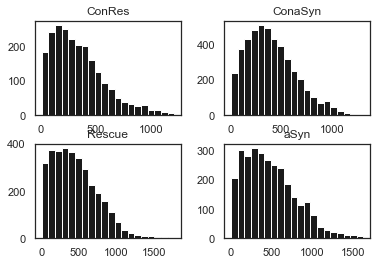

In [59]:
#Create a histogram
sns.set_style("white")
hist = df.hist(bins=20, grid=False, color='k')